In [44]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [45]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [46]:
tf.keras.backend.clear_session()

In [47]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [48]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [49]:
subject = 'Roraima - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [50]:
data = pd.read_csv('2003_mo_model_input_RR.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Roraima - IDH,Roraima - Consumo de Cimento (t),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Roraima - PIB - Estadual,Roraima - PIB - Construção Civil,Roraima - PIB - Per Capita,Roraima - PIB - Preços de Mercado,Roraima - Desemprego,Roraima - value
0,2003-1,0.734916,6.920,0.724032,-5331.049150,11.520143,1.611498,1.036534,1.772069e+08,7.330309e+06,0.969649,2.058778,1001.077198,1671.347636,25.569094,22.736364,82.325261,1.614960,6.128460e+06,332580.202821,12.101540,5.339136e+06,8.263084,0.294583
1,2003-2,0.734957,7.476,0.690297,-5318.079644,11.189862,1.450389,0.993449,1.773884e+08,7.335910e+06,0.950783,2.058778,1001.079258,1671.347636,25.575369,22.731191,82.325261,1.615759,6.136622e+06,332914.755543,12.103485,5.342057e+06,8.257123,0.296505
2,2003-3,0.734998,8.659,0.669681,-5436.417870,10.820792,1.870184,0.973020,1.775699e+08,7.341511e+06,0.938332,2.058778,1001.080459,1671.347636,25.579030,22.728173,82.325261,1.616226,6.144784e+06,333249.308265,12.105429,5.344978e+06,8.251161,0.298178
3,2003-4,0.735038,7.259,0.660494,-5707.015274,10.417840,1.355287,0.940489,1.777514e+08,7.347112e+06,0.926401,2.058778,1001.080588,1671.347636,25.579422,22.727849,82.325261,1.616276,6.152947e+06,333583.860987,12.107373,5.347899e+06,8.245199,0.299598
4,2003-5,0.735079,6.786,0.648337,-5599.317941,9.959690,1.585538,0.917493,1.779329e+08,7.352713e+06,0.951683,2.047445,1001.066958,1673.953674,25.600512,22.700959,82.163288,1.626211,6.161109e+06,333918.413709,12.109318,5.350821e+06,8.239238,0.300965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,9.133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000383,1001.876045,1372.952659,27.207036,20.463386,61.729585,2.409839,NaN,NaN,NaN,NaN,NaN,0.581560
236,2022-9,NaN,10.622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.249519,1001.506562,1422.382102,27.178478,20.413409,62.770426,2.197567,NaN,NaN,NaN,NaN,NaN,0.579849
237,2022-10,NaN,10.300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.332550,1001.337412,1429.642235,27.148597,20.398080,63.127190,2.079315,NaN,NaN,NaN,NaN,NaN,0.577718
238,2022-11,NaN,10.258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.465456,1001.289107,1422.380936,27.024825,20.368093,63.657698,2.027643,NaN,NaN,NaN,NaN,NaN,0.575950


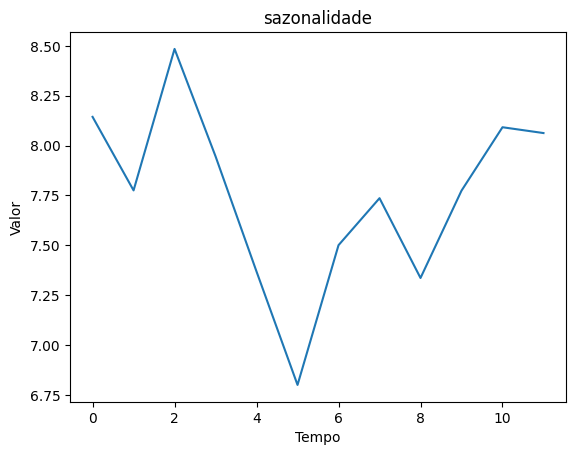

,sazonalidade
sazonalidade,
0,8.143825
1,7.775350
2,8.484300
3,7.945950
4,7.368600
5,6.800600
6,7.500850
7,7.736300
8,7.336450


In [51]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [52]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Roraima - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Roraima - PIB - Estadual,Roraima - PIB - Construção Civil,Roraima - PIB - Per Capita,Roraima - PIB - Preços de Mercado,Roraima - Desemprego,Roraima - value,sazonalidade,Roraima - Consumo de Cimento (t)
0,2003-1,0.734916,0.724032,-5331.049150,11.520143,1.611498,1.036534,1.772069e+08,7.330309e+06,0.969649,2.058778,1001.077198,1671.347636,25.569094,22.736364,82.325261,1.614960,6.128460e+06,332580.202821,12.101540,5.339136e+06,8.263084,0.294583,8.143825,6.920
1,2003-2,0.734957,0.690297,-5318.079644,11.189862,1.450389,0.993449,1.773884e+08,7.335910e+06,0.950783,2.058778,1001.079258,1671.347636,25.575369,22.731191,82.325261,1.615759,6.136622e+06,332914.755543,12.103485,5.342057e+06,8.257123,0.296505,7.775350,7.476
2,2003-3,0.734998,0.669681,-5436.417870,10.820792,1.870184,0.973020,1.775699e+08,7.341511e+06,0.938332,2.058778,1001.080459,1671.347636,25.579030,22.728173,82.325261,1.616226,6.144784e+06,333249.308265,12.105429,5.344978e+06,8.251161,0.298178,8.484300,8.659
3,2003-4,0.735038,0.660494,-5707.015274,10.417840,1.355287,0.940489,1.777514e+08,7.347112e+06,0.926401,2.058778,1001.080588,1671.347636,25.579422,22.727849,82.325261,1.616276,6.152947e+06,333583.860987,12.107373,5.347899e+06,8.245199,0.299598,7.945950,7.259
4,2003-5,0.735079,0.648337,-5599.317941,9.959690,1.585538,0.917493,1.779329e+08,7.352713e+06,0.951683,2.047445,1001.066958,1673.953674,25.600512,22.700959,82.163288,1.626211,6.161109e+06,333918.413709,12.109318,5.350821e+06,8.239238,0.300965,7.368600,6.786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000383,1001.876045,1372.952659,27.207036,20.463386,61.729585,2.409839,NaN,NaN,NaN,NaN,NaN,0.581560,7.736300,9.133
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.249519,1001.506562,1422.382102,27.178478,20.413409,62.770426,2.197567,NaN,NaN,NaN,NaN,NaN,0.579849,7.336450,10.622
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.332550,1001.337412,1429.642235,27.148597,20.398080,63.127190,2.079315,NaN,NaN,NaN,NaN,NaN,0.577718,7.774000,10.300
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.465456,1001.289107,1422.380936,27.024825,20.368093,63.657698,2.027643,NaN,NaN,NaN,NaN,NaN,0.575950,8.091850,10.258


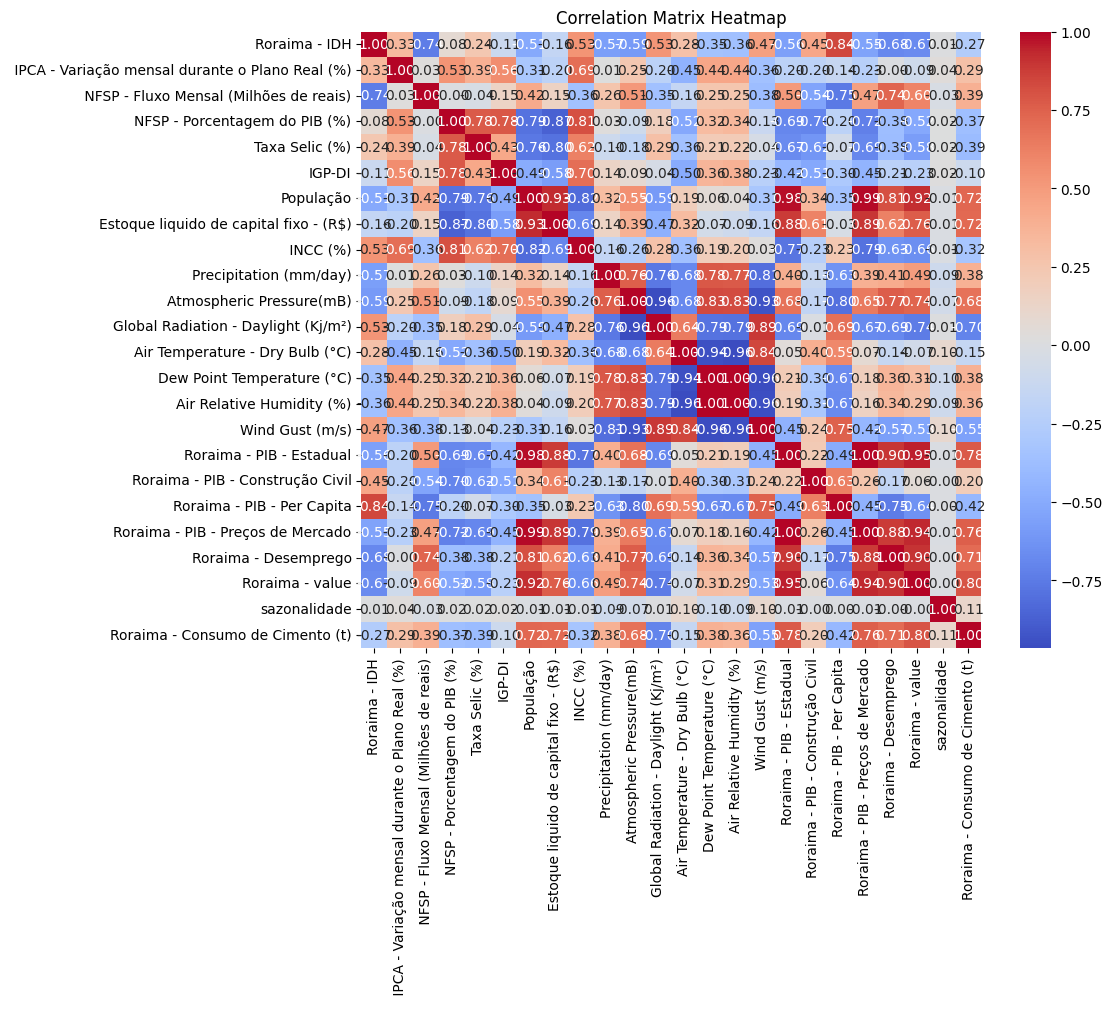

In [53]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [54]:
data =data.drop(['IGP-DI',
                 'Air Temperature - Dry Bulb (°C)'], axis=1)
data

,Unnamed: 0,Roraima - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Roraima - PIB - Estadual,Roraima - PIB - Construção Civil,Roraima - PIB - Per Capita,Roraima - PIB - Preços de Mercado,Roraima - Desemprego,Roraima - value,sazonalidade,Roraima - Consumo de Cimento (t)
0,2003-1,0.734916,0.724032,-5331.049150,11.520143,1.611498,1.772069e+08,7.330309e+06,0.969649,2.058778,1001.077198,1671.347636,22.736364,82.325261,1.614960,6.128460e+06,332580.202821,12.101540,5.339136e+06,8.263084,0.294583,8.143825,6.920
1,2003-2,0.734957,0.690297,-5318.079644,11.189862,1.450389,1.773884e+08,7.335910e+06,0.950783,2.058778,1001.079258,1671.347636,22.731191,82.325261,1.615759,6.136622e+06,332914.755543,12.103485,5.342057e+06,8.257123,0.296505,7.775350,7.476
2,2003-3,0.734998,0.669681,-5436.417870,10.820792,1.870184,1.775699e+08,7.341511e+06,0.938332,2.058778,1001.080459,1671.347636,22.728173,82.325261,1.616226,6.144784e+06,333249.308265,12.105429,5.344978e+06,8.251161,0.298178,8.484300,8.659
3,2003-4,0.735038,0.660494,-5707.015274,10.417840,1.355287,1.777514e+08,7.347112e+06,0.926401,2.058778,1001.080588,1671.347636,22.727849,82.325261,1.616276,6.152947e+06,333583.860987,12.107373,5.347899e+06,8.245199,0.299598,7.945950,7.259
4,2003-5,0.735079,0.648337,-5599.317941,9.959690,1.585538,1.779329e+08,7.352713e+06,0.951683,2.047445,1001.066958,1673.953674,22.700959,82.163288,1.626211,6.161109e+06,333918.413709,12.109318,5.350821e+06,8.239238,0.300965,7.368600,6.786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000383,1001.876045,1372.952659,20.463386,61.729585,2.409839,NaN,NaN,NaN,NaN,NaN,0.581560,7.736300,9.133
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.249519,1001.506562,1422.382102,20.413409,62.770426,2.197567,NaN,NaN,NaN,NaN,NaN,0.579849,7.336450,10.622
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.332550,1001.337412,1429.642235,20.398080,63.127190,2.079315,NaN,NaN,NaN,NaN,NaN,0.577718,7.774000,10.300
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.465456,1001.289107,1422.380936,20.368093,63.657698,2.027643,NaN,NaN,NaN,NaN,NaN,0.575950,8.091850,10.258


In [55]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Roraima - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Roraima - PIB - Estadual,Roraima - PIB - Construção Civil,Roraima - PIB - Per Capita,Roraima - PIB - Preços de Mercado,Roraima - Desemprego,Roraima - value,sazonalidade
0,-0.346657,2.723741,0.364808,4.398348,2.132459,-2.042341,-2.389042,3.122582,0.761168,0.377671,-0.221666,1.507280,1.538942,-1.004155,-1.650047,-2.537523,-1.382546,-1.820180,-0.695651,-0.837394,0.909841
1,-0.316945,2.350880,0.368956,4.222509,1.592202,-2.014760,-2.352139,2.970356,0.761168,0.378771,-0.221666,1.504467,1.538942,-1.003224,-1.633241,-2.453668,-1.340990,-1.796532,-0.700839,-0.805077,0.054811
2,-0.287234,2.123016,0.331110,4.026019,2.999926,-1.987179,-2.315236,2.869895,0.761168,0.379413,-0.221666,1.502826,1.538942,-1.002681,-1.616435,-2.369814,-1.299433,-1.772885,-0.706028,-0.776961,1.699898
3,-0.257523,2.021477,0.244570,3.811492,1.273293,-1.959598,-2.278333,2.773628,0.761168,0.379482,-0.221666,1.502650,1.538942,-1.002622,-1.599629,-2.285960,-1.257877,-1.749238,-0.711217,-0.753079,0.450681
4,-0.227812,1.887113,0.279013,3.567576,2.045407,-1.932017,-2.241431,2.977624,0.749354,0.372198,-0.211846,1.488028,1.526340,-0.991047,-1.582822,-2.202105,-1.216320,-1.725591,-0.716406,-0.730102,-0.889034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,-3.166795,-2.010387,2.953658,-0.572934,-1.311366,1.365911,0.389193,-1.749976,2.410241,0.922592,-0.690178,0.650907,0.590791,-0.970648,1.253468,-0.612057,-1.780820,1.251634,1.267469,1.568039,-0.035803
188,-3.318917,-1.870713,3.351323,-0.588777,-1.417143,1.376610,0.370392,-1.593005,2.178232,0.743729,-0.623222,0.485064,0.445193,-0.781727,1.245588,-0.616438,-1.802446,1.242511,1.252097,1.600280,-0.963637
189,-3.471040,-1.806230,3.404908,-0.612606,-1.597784,1.387308,0.351592,-1.351489,1.345019,0.730056,-0.584363,0.248499,0.234427,-0.563592,1.237708,-0.620818,-1.824072,1.233388,1.236726,1.635777,0.051678
190,-3.623162,-1.727496,3.671303,-0.640956,-1.400787,1.398006,0.332791,-1.198492,0.715249,0.804149,-0.599296,0.010725,0.092211,-0.295963,1.229828,-0.625199,-1.845698,1.224265,1.221354,1.674397,0.789235


In [56]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0      5.753
1      5.006
2      5.470
3      1.513
4      3.706
       ...  
235      NaN
236      NaN
237      NaN
238      NaN
239      NaN
Name: Roraima - Consumo de Cimento (t), Length: 240, dtype: float64

In [57]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Roraima - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Roraima - PIB - Estadual,Roraima - PIB - Construção Civil,Roraima - PIB - Per Capita,Roraima - PIB - Preços de Mercado,Roraima - Desemprego,Roraima - value,sazonalidade
0,-0.346657,2.723741,0.364808,4.398348,2.132459,-2.042341,-2.389042,3.122582,0.761168,0.377671,-0.221666,1.507280,1.538942,-1.004155,-1.650047,-2.537523,-1.382546,-1.820180,-0.695651,-0.837394,0.909841
1,-0.316945,2.350880,0.368956,4.222509,1.592202,-2.014760,-2.352139,2.970356,0.761168,0.378771,-0.221666,1.504467,1.538942,-1.003224,-1.633241,-2.453668,-1.340990,-1.796532,-0.700839,-0.805077,0.054811
2,-0.287234,2.123016,0.331110,4.026019,2.999926,-1.987179,-2.315236,2.869895,0.761168,0.379413,-0.221666,1.502826,1.538942,-1.002681,-1.616435,-2.369814,-1.299433,-1.772885,-0.706028,-0.776961,1.699898
3,-0.257523,2.021477,0.244570,3.811492,1.273293,-1.959598,-2.278333,2.773628,0.761168,0.379482,-0.221666,1.502650,1.538942,-1.002622,-1.599629,-2.285960,-1.257877,-1.749238,-0.711217,-0.753079,0.450681
4,-0.227812,1.887113,0.279013,3.567576,2.045407,-1.932017,-2.241431,2.977624,0.749354,0.372198,-0.211846,1.488028,1.526340,-0.991047,-1.582822,-2.202105,-1.216320,-1.725591,-0.716406,-0.730102,-0.889034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,-0.256163,-0.214006,1.216560,-0.607704,0.043807,1.031384,0.819304,-0.883659,0.031956,0.785476,-0.833372,0.091794,0.002360,-0.336021,1.210022,-0.560021,-0.995787,1.154680,1.464445,1.181073,0.054811
158,-0.349321,-0.434717,1.155373,-0.620523,0.210856,1.042716,0.808136,-0.950771,0.354081,1.057752,-0.930306,0.299639,0.248080,-0.554339,1.218026,-0.570604,-1.003856,1.167190,1.447722,1.186391,1.699898
159,-0.442479,-0.524091,1.056140,-0.631530,0.107070,1.054049,0.796969,-1.028465,1.036846,1.253094,-1.108416,0.660202,0.639967,-0.823699,1.226031,-0.581187,-1.011926,1.179699,1.430999,1.191228,0.450681
160,-0.535637,-0.614500,1.147619,-0.640320,0.392942,1.065381,0.785801,-1.103668,1.063091,1.460882,-1.111202,0.811740,0.824030,-0.980955,1.234036,-0.591770,-1.019995,1.192209,1.414277,1.195247,-0.889034


In [58]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       5.753
1       5.006
2       5.470
3       1.513
4       3.706
        ...  
157     6.557
158     8.184
159     8.092
160     7.806
161    10.831
Name: Roraima - Consumo de Cimento (t), Length: 162, dtype: float64

In [59]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [60]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 21)

In [61]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Roraima - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Roraima - PIB - Estadual,Roraima - PIB - Construção Civil,Roraima - PIB - Per Capita,Roraima - PIB - Preços de Mercado,Roraima - Desemprego,Roraima - value,sazonalidade
126,0.330327,0.888984,-0.230612,-0.460555,-1.048761,0.651397,0.944085,0.045243,1.509014,1.084239,-1.005309,0.950345,0.976156,-1.059559,0.751030,1.060935,0.050149,0.761717,0.763630,0.559901,-0.582154
127,0.319821,0.954254,-0.156322,-0.440372,-0.649312,0.664707,0.947319,0.061828,1.166096,0.754167,-0.904159,0.951498,0.910380,-1.059965,0.769813,0.950350,0.001472,0.775053,0.820001,0.589214,-0.035803
128,0.309316,1.045217,-0.120008,-0.419247,-0.535369,0.678017,0.950553,0.046225,0.565454,0.551876,-0.779402,0.854555,0.757541,-0.938565,0.788597,0.839766,-0.047205,0.788390,0.876373,0.618740,-0.963637
129,0.298810,1.176395,-0.143194,-0.397019,-1.288807,0.691327,0.953786,0.032522,0.169724,0.439059,-0.762598,0.616032,0.566065,-0.733777,0.807381,0.729182,-0.095883,0.801726,0.932744,0.648481,0.051678
130,0.288304,1.303259,-0.028712,-0.376532,-1.507550,0.704637,0.957020,0.042757,-0.058006,0.341615,-0.831561,0.415990,0.408141,-0.508176,0.826164,0.618597,-0.144560,0.815063,0.989115,0.678511,0.789235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,-3.166795,-2.010387,2.953658,-0.572934,-1.311366,1.365911,0.389193,-1.749976,2.410241,0.922592,-0.690178,0.650907,0.590791,-0.970648,1.253468,-0.612057,-1.780820,1.251634,1.267469,1.568039,-0.035803
188,-3.318917,-1.870713,3.351323,-0.588777,-1.417143,1.376610,0.370392,-1.593005,2.178232,0.743729,-0.623222,0.485064,0.445193,-0.781727,1.245588,-0.616438,-1.802446,1.242511,1.252097,1.600280,-0.963637
189,-3.471040,-1.806230,3.404908,-0.612606,-1.597784,1.387308,0.351592,-1.351489,1.345019,0.730056,-0.584363,0.248499,0.234427,-0.563592,1.237708,-0.620818,-1.824072,1.233388,1.236726,1.635777,0.051678
190,-3.623162,-1.727496,3.671303,-0.640956,-1.400787,1.398006,0.332791,-1.198492,0.715249,0.804149,-0.599296,0.010725,0.092211,-0.295963,1.229828,-0.625199,-1.845698,1.224265,1.221354,1.674397,0.789235


In [62]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 21)

In [63]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [64]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    train, train_val = validation_splitter(train_input, 7)
    target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                             return_sequences=True, 
                             input_shape=(reshaped_train.shape[1],
                                          reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(180,activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train, 
                        target, 
                        epochs=10000,
                        validation_data=(train_val,
                                         target_val),
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [65]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(50)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [66]:
winner_seed = get_a_good_seed(reshaped_train, 
                              reshaped_target, 
                              reshaped_test, 
                              reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[1589768076, 3494509968, 1580299680, 2557284238, 3687158932, 668320200, 3398839925, 988055574, 3635506361, 1508720698, 2271681693, 998794510, 4139013399, 3326663501, 650930867, 3071017747, 741310868, 203981812, 4182980776, 2132159959, 2985680118, 1782891203, 3208780091, 3637325952, 3393081206, 1114006901, 548659204, 2934213812, 183194852, 2400868018, 1171479837, 638373108, 1246790315, 791224346, 1398584953, 3123669921, 349324687, 1138129811, 1831156117, 1199086728, 3103264573, 2276056455, 2726370701, 646367381, 970025726, 992433193, 406910254, 3058183187, 634408327, 3473161083]


Step: 0 ___________________________________________
val_loss: 0.6414085626602173
winner_seed: 1589768076


Step: 1 ___________________________________________
val_loss: 0.6153996586799622
winner_seed: 3494509968


Step: 2 ___________________________________________
val_loss: 0.6288928985595703


Step: 3 ___________________________________________
val_loss: 0.6075360774993896
winner_seed: 2557284238


Step: 4 _

In [67]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 119ms/step - loss: 63.1452 - val_loss: 45.7083
Epoch 2/10000
4/4 [==============================] - 0s 9ms/step - loss: 27.8323 - val_loss: 7.0871
Epoch 3/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.8856 - val_loss: 3.6591
Epoch 4/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.8843 - val_loss: 2.6657
Epoch 5/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.6428 - val_loss: 2.4468
Epoch 6/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.5406 - val_loss: 2.3475
Epoch 7/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.6896 - val_loss: 2.6658
Epoch 8/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.6244 - val_loss: 2.2876
Epoch 9/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.5661 - val_loss: 2.7927
Epoch 10/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.7952 - val_loss: 2.5760
Epoc

Epoch 83/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.1897 - val_loss: 2.4558
Epoch 84/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.1630 - val_loss: 2.5297
Epoch 85/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.2129 - val_loss: 2.3165
Epoch 86/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.1831 - val_loss: 2.4676
Epoch 87/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.2676 - val_loss: 2.2605
Epoch 88/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.1735 - val_loss: 2.2272
Epoch 89/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.2062 - val_loss: 2.1332
Epoch 90/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.1720 - val_loss: 2.3908
Epoch 91/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.2296 - val_loss: 2.1419
Epoch 92/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.2163 - val_loss: 2.39

4/4 [==============================] - 0s 9ms/step - loss: 1.1489 - val_loss: 2.0410
Epoch 165/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.3068 - val_loss: 2.3195
Epoch 166/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.1085 - val_loss: 2.2515
Epoch 167/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.1469 - val_loss: 2.4254
Epoch 168/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.2447 - val_loss: 2.1097
Epoch 169/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.1485 - val_loss: 2.4483
Epoch 170/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.1272 - val_loss: 2.4203
Epoch 171/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.2444 - val_loss: 2.5645
Epoch 172/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.2828 - val_loss: 2.1885
Epoch 173/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.1304 - val_loss: 2.0151
Epoch 

4/4 [==============================] - 0s 8ms/step - loss: 1.1107 - val_loss: 2.1409
Epoch 246/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.0446 - val_loss: 2.1488
Epoch 247/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.1275 - val_loss: 2.2771
Epoch 248/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.1303 - val_loss: 2.1765
Epoch 249/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.1672 - val_loss: 2.1427
Epoch 250/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.0643 - val_loss: 2.2493
Epoch 251/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.1298 - val_loss: 2.1670
Epoch 252/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.1748 - val_loss: 2.1205
Epoch 253/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.1604 - val_loss: 1.9973
Epoch 254/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.0879 - val_loss: 2.2473
Epoch

4/4 [==============================] - 0s 9ms/step - loss: 1.1431 - val_loss: 2.2641
Epoch 327/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.1707 - val_loss: 2.1496
Epoch 328/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.1373 - val_loss: 1.9410
Epoch 329/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0928 - val_loss: 2.1760
Epoch 330/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.1080 - val_loss: 2.3454
Epoch 331/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.1401 - val_loss: 2.2393
Epoch 332/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.1227 - val_loss: 2.0558
Epoch 333/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0802 - val_loss: 2.0996
Epoch 334/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.1538 - val_loss: 2.0873
Epoch 335/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.1232 - val_loss: 2.0367
Epoch 

4/4 [==============================] - 0s 9ms/step - loss: 1.0277 - val_loss: 2.0226
Epoch 408/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0789 - val_loss: 2.0102
Epoch 409/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0666 - val_loss: 2.0009
Epoch 410/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.0566 - val_loss: 2.0016
Epoch 411/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.1056 - val_loss: 1.9836
Epoch 412/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0931 - val_loss: 2.1000
Epoch 413/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0726 - val_loss: 2.0840
Epoch 414/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.0715 - val_loss: 1.9553
Epoch 415/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.1386 - val_loss: 2.1954
Epoch 416/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0860 - val_loss: 2.1412
Epoch

4/4 [==============================] - 0s 8ms/step - loss: 1.1030 - val_loss: 2.0149
Epoch 489/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0304 - val_loss: 2.0921
Epoch 490/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.1037 - val_loss: 1.9834
Epoch 491/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.0925 - val_loss: 2.0598
Epoch 492/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.1356 - val_loss: 1.9638
Epoch 493/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0613 - val_loss: 1.9753
Epoch 494/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0811 - val_loss: 1.8217
Epoch 495/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.1601 - val_loss: 1.9027
Epoch 496/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.0714 - val_loss: 1.9993
Epoch 497/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.0876 - val_loss: 1.9143
Epoc

4/4 [==============================] - 0s 8ms/step - loss: 1.1268 - val_loss: 1.9092
Epoch 570/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.0909 - val_loss: 2.0740
Epoch 571/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.1206 - val_loss: 1.9188
Epoch 572/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.0450 - val_loss: 1.9033
Epoch 573/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0670 - val_loss: 2.0212
Epoch 574/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.1459 - val_loss: 2.1172
Epoch 575/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.1407 - val_loss: 2.1711
Epoch 576/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.0833 - val_loss: 1.9089
Epoch 577/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0755 - val_loss: 1.9582
Epoch 578/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0817 - val_loss: 2.0142
Epoch 

4/4 [==============================] - 0s 8ms/step - loss: 1.0207 - val_loss: 1.9490
Epoch 651/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.0690 - val_loss: 1.9805
Epoch 652/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.1047 - val_loss: 2.1062
Epoch 653/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0246 - val_loss: 2.1771
Epoch 654/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.1825 - val_loss: 2.1821
Epoch 655/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.0192 - val_loss: 2.1366
Epoch 656/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.0451 - val_loss: 2.2064
Epoch 657/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0141 - val_loss: 2.2325
Epoch 658/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0774 - val_loss: 2.0276
Epoch 659/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0452 - val_loss: 1.9801
Epoc

4/4 [==============================] - 0s 8ms/step - loss: 1.0051 - val_loss: 1.9096
Epoch 732/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.0194 - val_loss: 2.0480
Epoch 733/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0937 - val_loss: 2.1153
Epoch 734/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0918 - val_loss: 1.9592
Epoch 735/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0203 - val_loss: 1.9510
Epoch 736/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.0731 - val_loss: 2.1212
Epoch 737/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0557 - val_loss: 1.9789
Epoch 738/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0332 - val_loss: 2.0287
Epoch 739/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.9740 - val_loss: 1.9053
Epoch 740/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.0059 - val_loss: 1.9267
Epoch

4/4 [==============================] - 0s 9ms/step - loss: 0.9788 - val_loss: 2.1384
Epoch 813/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0228 - val_loss: 1.9991
Epoch 814/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.9573 - val_loss: 1.8947
Epoch 815/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0067 - val_loss: 1.8988
Epoch 816/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.0139 - val_loss: 1.8113
Epoch 817/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0193 - val_loss: 1.8601
Epoch 818/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.9936 - val_loss: 1.9773
Epoch 819/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.0355 - val_loss: 2.1423
Epoch 820/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.0337 - val_loss: 1.9404
Epoch 821/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.0466 - val_loss: 1.7803
Epo

4/4 [==============================] - 0s 9ms/step - loss: 0.9678 - val_loss: 1.8228
Epoch 894/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.0474 - val_loss: 1.7220
Epoch 895/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.9833 - val_loss: 1.7785
Epoch 896/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.9221 - val_loss: 1.7134
Epoch 897/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.9787 - val_loss: 1.8603
Epoch 898/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0141 - val_loss: 1.8622
Epoch 899/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.9551 - val_loss: 1.9878
Epoch 900/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.9519 - val_loss: 1.9396
Epoch 901/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.9843 - val_loss: 2.0217
Epoch 902/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.9672 - val_loss: 1.8439
Epoc

4/4 [==============================] - 0s 8ms/step - loss: 0.9965 - val_loss: 2.1572
Epoch 975/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0456 - val_loss: 2.0377
Epoch 976/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0903 - val_loss: 1.8020
Epoch 977/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.9662 - val_loss: 1.8674
Epoch 978/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.9265 - val_loss: 1.8478
Epoch 979/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0097 - val_loss: 1.7822
Epoch 980/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.9360 - val_loss: 1.7310
Epoch 981/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.9410 - val_loss: 1.9618
Epoch 982/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.9594 - val_loss: 1.7100
Epoch 983/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.9158 - val_loss: 1.6912
Epoch 

4/4 [==============================] - 0s 9ms/step - loss: 0.9442 - val_loss: 1.6567
Epoch 1055/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0271 - val_loss: 1.9704
Epoch 1056/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.9884 - val_loss: 1.6972
Epoch 1057/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.9409 - val_loss: 1.8310
Epoch 1058/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.9214 - val_loss: 1.7964
Epoch 1059/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.9398 - val_loss: 1.6757
Epoch 1060/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.9597 - val_loss: 1.6954
Epoch 1061/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.9624 - val_loss: 1.7491
Epoch 1062/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.9357 - val_loss: 1.7623
Epoch 1063/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.9746 - val_loss: 1.6

4/4 [==============================] - 0s 8ms/step - loss: 0.9081 - val_loss: 1.5765
Epoch 1135/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.8912 - val_loss: 1.5367
Epoch 1136/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.9398 - val_loss: 1.7179
Epoch 1137/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.9323 - val_loss: 1.5936
Epoch 1138/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.8225 - val_loss: 1.6392
Epoch 1139/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.8325 - val_loss: 1.5664
Epoch 1140/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.9132 - val_loss: 1.5616
Epoch 1141/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.9675 - val_loss: 1.6407
Epoch 1142/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.9103 - val_loss: 1.6256
Epoch 1143/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.9526 - val_loss: 1.63

4/4 [==============================] - 0s 10ms/step - loss: 0.9088 - val_loss: 1.6263
Epoch 1215/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.8915 - val_loss: 1.4778
Epoch 1216/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.8705 - val_loss: 1.6339
Epoch 1217/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.8256 - val_loss: 1.5706
Epoch 1218/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.8362 - val_loss: 1.6718
Epoch 1219/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.9211 - val_loss: 1.5497
Epoch 1220/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.8641 - val_loss: 1.6236
Epoch 1221/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7875 - val_loss: 1.5787
Epoch 1222/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.9362 - val_loss: 1.7194
Epoch 1223/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.8945 - val_loss: 1

4/4 [==============================] - 0s 8ms/step - loss: 0.9085 - val_loss: 1.4698
Epoch 1295/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.8461 - val_loss: 1.4856
Epoch 1296/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7811 - val_loss: 1.4854
Epoch 1297/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.8135 - val_loss: 1.5262
Epoch 1298/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.8555 - val_loss: 1.5677
Epoch 1299/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.8704 - val_loss: 1.5174
Epoch 1300/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7930 - val_loss: 1.5693
Epoch 1301/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.9781 - val_loss: 1.4267
Epoch 1302/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.8372 - val_loss: 1.5538
Epoch 1303/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.9730 - val_loss: 1.6

4/4 [==============================] - 0s 8ms/step - loss: 0.8245 - val_loss: 1.4933
Epoch 1375/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7752 - val_loss: 1.3946
Epoch 1376/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.9124 - val_loss: 1.5070
Epoch 1377/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7961 - val_loss: 1.5138
Epoch 1378/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7685 - val_loss: 1.4585
Epoch 1379/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.8058 - val_loss: 1.4731
Epoch 1380/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.8178 - val_loss: 1.4071
Epoch 1381/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.8491 - val_loss: 1.4463
Epoch 1382/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.8882 - val_loss: 1.4666
Epoch 1383/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.8266 - val_loss: 1.35

4/4 [==============================] - 0s 10ms/step - loss: 0.8721 - val_loss: 1.4421
Epoch 1455/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.8553 - val_loss: 1.6866
Epoch 1456/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.8388 - val_loss: 1.4167
Epoch 1457/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.8469 - val_loss: 1.4411
Epoch 1458/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.8494 - val_loss: 1.3593
Epoch 1459/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.7903 - val_loss: 1.4321
Epoch 1460/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.8742 - val_loss: 1.4249
Epoch 1461/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7773 - val_loss: 1.3872
Epoch 1462/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7498 - val_loss: 1.4118
Epoch 1463/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.8175 - val_loss: 1.4

4/4 [==============================] - 0s 9ms/step - loss: 0.7625 - val_loss: 1.3542
Epoch 1535/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.7642 - val_loss: 1.3280
Epoch 1536/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.7594 - val_loss: 1.3444
Epoch 1537/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.7973 - val_loss: 1.3344
Epoch 1538/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7083 - val_loss: 1.3585
Epoch 1539/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.8231 - val_loss: 1.4375
Epoch 1540/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.7649 - val_loss: 1.4807
Epoch 1541/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.8063 - val_loss: 1.4265
Epoch 1542/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.8264 - val_loss: 1.4294
Epoch 1543/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7961 - val_loss: 1.43

4/4 [==============================] - 0s 10ms/step - loss: 0.7584 - val_loss: 1.3263
Epoch 1615/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7062 - val_loss: 1.4067
Epoch 1616/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7258 - val_loss: 1.4230
Epoch 1617/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7813 - val_loss: 1.3664
Epoch 1618/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.6924 - val_loss: 1.3733
Epoch 1619/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7355 - val_loss: 1.3950
Epoch 1620/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.7255 - val_loss: 1.3639
Epoch 1621/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.8145 - val_loss: 1.3452
Epoch 1622/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7862 - val_loss: 1.4574
Epoch 1623/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7577 - val_loss: 1.

4/4 [==============================] - 0s 11ms/step - loss: 0.7430 - val_loss: 1.3771
Epoch 1695/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.7645 - val_loss: 1.2762
Epoch 1696/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.6881 - val_loss: 1.5314
Epoch 1697/10000
4/4 [==============================] - 0s 12ms/step - loss: 0.7588 - val_loss: 1.4226
Epoch 1698/10000
4/4 [==============================] - 0s 11ms/step - loss: 0.6928 - val_loss: 1.4254
Epoch 1699/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7069 - val_loss: 1.3504
Epoch 1700/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7020 - val_loss: 1.2344
Epoch 1701/10000
4/4 [==============================] - 0s 11ms/step - loss: 0.7314 - val_loss: 1.2412
Epoch 1702/10000
4/4 [==============================] - 0s 11ms/step - loss: 0.7925 - val_loss: 1.2707
Epoch 1703/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.7994 - val_los

4/4 [==============================] - 0s 9ms/step - loss: 0.6062 - val_loss: 1.3799
Epoch 1775/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.7141 - val_loss: 1.3073
Epoch 1776/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.6889 - val_loss: 1.3369
Epoch 1777/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.6793 - val_loss: 1.2975
Epoch 1778/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.6890 - val_loss: 1.5355
Epoch 1779/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7286 - val_loss: 1.2976
Epoch 1780/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7076 - val_loss: 1.3236
Epoch 1781/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.8397 - val_loss: 1.2737
Epoch 1782/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.6523 - val_loss: 1.3333
Epoch 1783/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.7048 - val_loss: 1.2

4/4 [==============================] - 0s 10ms/step - loss: 0.6398 - val_loss: 1.6353
Epoch 1855/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7527 - val_loss: 1.4803
Epoch 1856/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7170 - val_loss: 1.2652
Epoch 1857/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.7497 - val_loss: 1.2226
Epoch 1858/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.6531 - val_loss: 1.3981
Epoch 1859/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7578 - val_loss: 1.3821
Epoch 1860/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.6785 - val_loss: 1.3538
Epoch 1861/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.6692 - val_loss: 1.4302
Epoch 1862/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.6321 - val_loss: 1.2584
Epoch 1863/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.6688 - val_loss: 1.2

4/4 [==============================] - 0s 9ms/step - loss: 0.6466 - val_loss: 1.2651
Epoch 1935/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.6457 - val_loss: 1.2752
Epoch 1936/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.6825 - val_loss: 1.2883
Epoch 1937/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.6793 - val_loss: 1.4297
Epoch 1938/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.6682 - val_loss: 1.3206
Epoch 1939/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.6906 - val_loss: 1.2991
Epoch 1940/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.6623 - val_loss: 1.2325
Epoch 1941/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.7514 - val_loss: 1.3688
Epoch 1942/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.6818 - val_loss: 1.3012
Epoch 1943/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.7556 - val_loss: 

4/4 [==============================] - 0s 9ms/step - loss: 0.7003 - val_loss: 1.4662
Epoch 2015/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.7323 - val_loss: 1.4250
Epoch 2016/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.7055 - val_loss: 1.3714
Epoch 2017/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.6777 - val_loss: 1.4489
Epoch 2018/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7480 - val_loss: 1.4329
Epoch 2019/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.7324 - val_loss: 1.3861
Epoch 2020/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.6453 - val_loss: 1.3055
Epoch 2021/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.6909 - val_loss: 1.3200
Epoch 2022/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.6007 - val_loss: 1.3246
Epoch 2023/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.6236 - val_loss: 1.2

4/4 [==============================] - 0s 10ms/step - loss: 0.6759 - val_loss: 1.2497
Epoch 2095/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.6680 - val_loss: 1.3103
Epoch 2096/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.6575 - val_loss: 1.3164
Epoch 2097/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.6504 - val_loss: 1.2566
Epoch 2098/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.6550 - val_loss: 1.3124
Epoch 2099/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.6747 - val_loss: 1.3253
Epoch 2100/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.6458 - val_loss: 1.2319
Epoch 2101/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.6845 - val_loss: 1.3000
Epoch 2102/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.6714 - val_loss: 1.3170
Epoch 2103/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.6620 - val_loss: 1.

4/4 [==============================] - 0s 9ms/step - loss: 0.5803 - val_loss: 1.4279
Epoch 2175/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.6624 - val_loss: 1.1923
Epoch 2176/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.5738 - val_loss: 1.2161
Epoch 2177/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.6052 - val_loss: 1.1688
Epoch 2178/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.6303 - val_loss: 1.3062
Epoch 2179/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.5890 - val_loss: 1.2162
Epoch 2180/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7525 - val_loss: 1.3445
Epoch 2181/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.6559 - val_loss: 1.1476
Epoch 2182/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.6108 - val_loss: 1.2845
Epoch 2183/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.5695 - val_loss: 1.3

4/4 [==============================] - 0s 10ms/step - loss: 0.6322 - val_loss: 1.3450
Epoch 2255/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.5631 - val_loss: 1.2155
Epoch 2256/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.5894 - val_loss: 1.1181
Epoch 2257/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.6129 - val_loss: 1.1530
Epoch 2258/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.6130 - val_loss: 1.4108
Epoch 2259/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.5942 - val_loss: 1.3191
Epoch 2260/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.6127 - val_loss: 1.2305
Epoch 2261/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.5940 - val_loss: 1.2352
Epoch 2262/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.5868 - val_loss: 1.3498
Epoch 2263/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.6121 - val_loss: 1.3

4/4 [==============================] - 0s 10ms/step - loss: 0.6398 - val_loss: 1.0636
Epoch 2335/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.6059 - val_loss: 1.4711
Epoch 2336/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.6310 - val_loss: 1.2234
Epoch 2337/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.5421 - val_loss: 1.0378
Epoch 2338/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.5552 - val_loss: 1.3221
Epoch 2339/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.6564 - val_loss: 1.2011
Epoch 2340/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.5013 - val_loss: 1.0986
Epoch 2341/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.6051 - val_loss: 1.4340
Epoch 2342/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.5745 - val_loss: 1.1259
Epoch 2343/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.6477 - val_loss: 1.1

4/4 [==============================] - 0s 8ms/step - loss: 0.8350 - val_loss: 1.3117
Epoch 2415/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.8446 - val_loss: 1.2474
Epoch 2416/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7053 - val_loss: 1.1503
Epoch 2417/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.8469 - val_loss: 1.2163
Epoch 2418/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.6648 - val_loss: 1.1743
Epoch 2419/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.6738 - val_loss: 1.0884
Epoch 2420/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7497 - val_loss: 1.1576
Epoch 2421/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.7450 - val_loss: 1.1112
Epoch 2422/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.6359 - val_loss: 1.1312
Epoch 2423/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.6612 - val_loss: 1.12

4/4 [==============================] - 0s 8ms/step - loss: 0.5268 - val_loss: 1.0688
Epoch 2495/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.5417 - val_loss: 1.1766
Epoch 2496/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.4945 - val_loss: 1.0451
Epoch 2497/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.5624 - val_loss: 1.0596
Epoch 2498/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.6253 - val_loss: 1.0773
Epoch 2499/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.5130 - val_loss: 1.1786
Epoch 2500/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.6057 - val_loss: 1.0517
Epoch 2501/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.6304 - val_loss: 1.0947
Epoch 2502/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.6204 - val_loss: 1.1280
Epoch 2503/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.5297 - val_loss: 1.10

4/4 [==============================] - 0s 8ms/step - loss: 0.5365 - val_loss: 1.0754
Epoch 2575/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.5087 - val_loss: 1.1117
Epoch 2576/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.4945 - val_loss: 1.0995
Epoch 2577/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.5138 - val_loss: 1.1701
Epoch 2578/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.5205 - val_loss: 1.1860
Epoch 2579/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.5167 - val_loss: 1.0061
Epoch 2580/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.4848 - val_loss: 1.0618
Epoch 2581/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.5894 - val_loss: 1.0509
Epoch 2582/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.5626 - val_loss: 1.1212
Epoch 2583/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.5751 - val_loss: 1.04

4/4 [==============================] - 0s 9ms/step - loss: 0.5606 - val_loss: 1.0553
Epoch 2655/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.5071 - val_loss: 0.9850
Epoch 2656/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.5133 - val_loss: 0.9748
Epoch 2657/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.5289 - val_loss: 0.9960
Epoch 2658/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.5204 - val_loss: 1.0369
Epoch 2659/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.5188 - val_loss: 1.0455
Epoch 2660/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.5203 - val_loss: 1.0363
Epoch 2661/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.5687 - val_loss: 1.0113
Epoch 2662/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.5342 - val_loss: 1.0590
Epoch 2663/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.5527 - val_loss: 1.23

4/4 [==============================] - 0s 8ms/step - loss: 0.5181 - val_loss: 1.0299
Epoch 2735/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.4903 - val_loss: 1.0684
Epoch 2736/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.5113 - val_loss: 1.0273
Epoch 2737/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.5744 - val_loss: 1.0379
Epoch 2738/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.5119 - val_loss: 1.1466
Epoch 2739/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.4907 - val_loss: 1.1316
Epoch 2740/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.4958 - val_loss: 1.0343
Epoch 2741/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.4855 - val_loss: 1.0340
Epoch 2742/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.5397 - val_loss: 1.0878
Epoch 2743/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.5936 - val_loss: 1.0

4/4 [==============================] - 0s 9ms/step - loss: 0.4667 - val_loss: 0.9949
Epoch 2815/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.5504 - val_loss: 1.0290
Epoch 2816/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.5209 - val_loss: 1.0080
Epoch 2817/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.5312 - val_loss: 1.0011
Epoch 2818/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.4710 - val_loss: 1.0075
Epoch 2819/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.5490 - val_loss: 1.0053
Epoch 2820/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.5121 - val_loss: 1.0829
Epoch 2821/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.5149 - val_loss: 1.2817
Epoch 2822/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.5252 - val_loss: 0.9617
Epoch 2823/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.5046 - val_loss: 1.02

4/4 [==============================] - 0s 9ms/step - loss: 0.4982 - val_loss: 1.0306
Epoch 2895/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.5801 - val_loss: 1.0632
Epoch 2896/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.4877 - val_loss: 1.0171
Epoch 2897/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.4771 - val_loss: 1.0319
Epoch 2898/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.4385 - val_loss: 1.0841
Epoch 2899/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.4680 - val_loss: 1.0637
Epoch 2900/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.4692 - val_loss: 0.9862
Epoch 2901/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.5263 - val_loss: 1.0300
Epoch 2902/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.5461 - val_loss: 1.3323
Epoch 2903/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.5257 - val_loss: 1.0

4/4 [==============================] - 0s 8ms/step - loss: 0.4959 - val_loss: 1.1499
Epoch 2975/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.5034 - val_loss: 1.0597
Epoch 2976/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.5100 - val_loss: 1.1147
Epoch 2977/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.5160 - val_loss: 1.0000
Epoch 2978/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.4526 - val_loss: 1.0873
Epoch 2979/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.4748 - val_loss: 0.9273
Epoch 2980/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.4715 - val_loss: 1.1865
Epoch 2981/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.5152 - val_loss: 0.9598
Epoch 2982/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.5025 - val_loss: 0.9828
Epoch 2983/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.4626 - val_loss: 1.07

4/4 [==============================] - 0s 7ms/step - loss: 0.4697 - val_loss: 1.0111
Epoch 3055/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.5045 - val_loss: 1.1758
Epoch 3056/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4956 - val_loss: 0.9421
Epoch 3057/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4347 - val_loss: 0.9718
Epoch 3058/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4761 - val_loss: 0.9099
Epoch 3059/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4733 - val_loss: 0.9708
Epoch 3060/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4886 - val_loss: 0.9151
Epoch 3061/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4451 - val_loss: 0.9631
Epoch 3062/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.5021 - val_loss: 0.8904
Epoch 3063/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4472 - val_loss: 1.05

4/4 [==============================] - 0s 7ms/step - loss: 0.5111 - val_loss: 1.0347
Epoch 3135/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4479 - val_loss: 0.9964
Epoch 3136/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.4565 - val_loss: 1.0026
Epoch 3137/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4806 - val_loss: 0.9353
Epoch 3138/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4975 - val_loss: 0.9093
Epoch 3139/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4825 - val_loss: 0.9293
Epoch 3140/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.5336 - val_loss: 0.9686
Epoch 3141/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4901 - val_loss: 1.1561
Epoch 3142/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4481 - val_loss: 0.9879
Epoch 3143/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4518 - val_loss: 0.99

4/4 [==============================] - 0s 7ms/step - loss: 0.4774 - val_loss: 0.9845
Epoch 3215/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4694 - val_loss: 1.0563
Epoch 3216/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.4886 - val_loss: 1.3180
Epoch 3217/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4468 - val_loss: 1.3259
Epoch 3218/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.5193 - val_loss: 0.9538
Epoch 3219/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4389 - val_loss: 0.9061
Epoch 3220/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4586 - val_loss: 0.8582
Epoch 3221/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.4489 - val_loss: 0.8936
Epoch 3222/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4371 - val_loss: 1.2378
Epoch 3223/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.4797 - val_loss: 0.98

4/4 [==============================] - 0s 7ms/step - loss: 0.4143 - val_loss: 0.9020
Epoch 3295/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3951 - val_loss: 0.8844
Epoch 3296/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4402 - val_loss: 1.1126
Epoch 3297/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4361 - val_loss: 0.9135
Epoch 3298/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3965 - val_loss: 1.0233
Epoch 3299/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.4404 - val_loss: 0.8950
Epoch 3300/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4136 - val_loss: 0.8369
Epoch 3301/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.5280 - val_loss: 0.9300
Epoch 3302/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4431 - val_loss: 0.8929
Epoch 3303/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3759 - val_loss: 1.01

4/4 [==============================] - 0s 7ms/step - loss: 0.4770 - val_loss: 1.0142
Epoch 3375/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.5167 - val_loss: 1.1404
Epoch 3376/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4707 - val_loss: 1.0759
Epoch 3377/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4551 - val_loss: 0.9443
Epoch 3378/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4206 - val_loss: 0.8923
Epoch 3379/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4245 - val_loss: 0.9420
Epoch 3380/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4211 - val_loss: 1.0130
Epoch 3381/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4161 - val_loss: 0.9062
Epoch 3382/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4625 - val_loss: 0.9255
Epoch 3383/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4708 - val_loss: 0.97

4/4 [==============================] - 0s 7ms/step - loss: 0.3923 - val_loss: 0.8590
Epoch 3455/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3654 - val_loss: 0.8749
Epoch 3456/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4826 - val_loss: 0.9902
Epoch 3457/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4322 - val_loss: 0.7982
Epoch 3458/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4553 - val_loss: 0.8543
Epoch 3459/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3692 - val_loss: 0.8464
Epoch 3460/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4165 - val_loss: 0.7992
Epoch 3461/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4268 - val_loss: 0.8881
Epoch 3462/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4679 - val_loss: 0.8319
Epoch 3463/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4532 - val_loss: 1.20

4/4 [==============================] - 0s 7ms/step - loss: 0.4545 - val_loss: 0.8083
Epoch 3535/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4607 - val_loss: 0.9630
Epoch 3536/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4293 - val_loss: 0.8069
Epoch 3537/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3939 - val_loss: 0.8209
Epoch 3538/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4489 - val_loss: 0.7584
Epoch 3539/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4018 - val_loss: 0.8263
Epoch 3540/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4027 - val_loss: 1.3375
Epoch 3541/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.5368 - val_loss: 0.9503
Epoch 3542/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4656 - val_loss: 0.8182
Epoch 3543/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3607 - val_loss: 0.92

4/4 [==============================] - 0s 7ms/step - loss: 0.4454 - val_loss: 0.8656
Epoch 3615/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3954 - val_loss: 0.9211
Epoch 3616/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4170 - val_loss: 0.8472
Epoch 3617/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4459 - val_loss: 0.9076
Epoch 3618/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3883 - val_loss: 1.1197
Epoch 3619/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3786 - val_loss: 0.9277
Epoch 3620/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4074 - val_loss: 0.8574
Epoch 3621/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3957 - val_loss: 0.7893
Epoch 3622/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4339 - val_loss: 0.9178
Epoch 3623/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3892 - val_loss: 0.79

4/4 [==============================] - 0s 7ms/step - loss: 0.5728 - val_loss: 1.4784
Epoch 3695/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4067 - val_loss: 0.8289
Epoch 3696/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4584 - val_loss: 0.8829
Epoch 3697/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4333 - val_loss: 0.9265
Epoch 3698/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4543 - val_loss: 1.1585
Epoch 3699/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4069 - val_loss: 0.8872
Epoch 3700/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4736 - val_loss: 1.0163
Epoch 3701/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3671 - val_loss: 0.8732
Epoch 3702/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4649 - val_loss: 0.8236
Epoch 3703/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4275 - val_loss: 0.85

4/4 [==============================] - 0s 7ms/step - loss: 0.3974 - val_loss: 0.9766
Epoch 3775/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4318 - val_loss: 0.7492
Epoch 3776/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3602 - val_loss: 0.7561
Epoch 3777/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3910 - val_loss: 0.7700
Epoch 3778/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3808 - val_loss: 0.7120
Epoch 3779/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4205 - val_loss: 0.7915
Epoch 3780/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4274 - val_loss: 0.9193
Epoch 3781/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3568 - val_loss: 0.9965
Epoch 3782/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3220 - val_loss: 1.0397
Epoch 3783/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3496 - val_loss: 0.93

4/4 [==============================] - 0s 8ms/step - loss: 0.4037 - val_loss: 1.0050
Epoch 3855/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3995 - val_loss: 0.8268
Epoch 3856/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3682 - val_loss: 0.8021
Epoch 3857/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3883 - val_loss: 0.9090
Epoch 3858/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4223 - val_loss: 0.8469
Epoch 3859/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3731 - val_loss: 1.0277
Epoch 3860/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4354 - val_loss: 0.9310
Epoch 3861/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.4011 - val_loss: 0.9271
Epoch 3862/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3863 - val_loss: 0.7633
Epoch 3863/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3780 - val_loss: 0.82

4/4 [==============================] - 0s 8ms/step - loss: 0.3547 - val_loss: 0.6759
Epoch 3935/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.4163 - val_loss: 0.8225
Epoch 3936/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4057 - val_loss: 0.8970
Epoch 3937/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3493 - val_loss: 0.7108
Epoch 3938/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3449 - val_loss: 0.6901
Epoch 3939/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3426 - val_loss: 0.8630
Epoch 3940/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3984 - val_loss: 1.0054
Epoch 3941/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3829 - val_loss: 0.7440
Epoch 3942/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3808 - val_loss: 0.8987
Epoch 3943/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.4193 - val_loss: 0.71

4/4 [==============================] - 0s 8ms/step - loss: 0.4481 - val_loss: 0.9122
Epoch 4015/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3550 - val_loss: 0.8177
Epoch 4016/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.4084 - val_loss: 0.8366
Epoch 4017/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.4029 - val_loss: 0.8770
Epoch 4018/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3984 - val_loss: 0.7598
Epoch 4019/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3508 - val_loss: 0.8675
Epoch 4020/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3958 - val_loss: 0.7635
Epoch 4021/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3777 - val_loss: 0.9307
Epoch 4022/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.2747 - val_loss: 1.0407
Epoch 4023/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3661 - val_loss: 0.79

4/4 [==============================] - 0s 8ms/step - loss: 0.3255 - val_loss: 1.0390
Epoch 4095/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3516 - val_loss: 0.6784
Epoch 4096/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3569 - val_loss: 0.9375
Epoch 4097/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3770 - val_loss: 0.8064
Epoch 4098/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3352 - val_loss: 0.8081
Epoch 4099/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2914 - val_loss: 0.6669
Epoch 4100/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3537 - val_loss: 0.9897
Epoch 4101/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3955 - val_loss: 1.0785
Epoch 4102/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3793 - val_loss: 1.0217
Epoch 4103/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3845 - val_loss: 0.87

4/4 [==============================] - 0s 7ms/step - loss: 0.3125 - val_loss: 0.7462
Epoch 4175/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3805 - val_loss: 0.6203
Epoch 4176/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.3723 - val_loss: 0.7316
Epoch 4177/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3239 - val_loss: 1.0890
Epoch 4178/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3622 - val_loss: 0.7872
Epoch 4179/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3428 - val_loss: 0.6864
Epoch 4180/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3093 - val_loss: 0.8714
Epoch 4181/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3068 - val_loss: 0.9198
Epoch 4182/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3110 - val_loss: 0.8634
Epoch 4183/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3495 - val_loss: 1.10

4/4 [==============================] - 0s 7ms/step - loss: 0.3291 - val_loss: 0.6207
Epoch 4255/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3041 - val_loss: 0.7598
Epoch 4256/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2823 - val_loss: 0.6220
Epoch 4257/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2609 - val_loss: 0.6551
Epoch 4258/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3580 - val_loss: 0.6658
Epoch 4259/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.4121 - val_loss: 0.8923
Epoch 4260/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3598 - val_loss: 0.7932
Epoch 4261/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3884 - val_loss: 0.8250
Epoch 4262/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3092 - val_loss: 0.7396
Epoch 4263/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3168 - val_loss: 0.95

4/4 [==============================] - 0s 7ms/step - loss: 0.3612 - val_loss: 0.7064
Epoch 4335/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3062 - val_loss: 0.7263
Epoch 4336/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2499 - val_loss: 0.6584
Epoch 4337/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3053 - val_loss: 0.7287
Epoch 4338/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2859 - val_loss: 0.6820
Epoch 4339/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2850 - val_loss: 0.6759
Epoch 4340/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2946 - val_loss: 0.8602
Epoch 4341/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3115 - val_loss: 0.7044
Epoch 4342/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2956 - val_loss: 0.6676
Epoch 4343/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3677 - val_loss: 0.70

4/4 [==============================] - 0s 7ms/step - loss: 0.3180 - val_loss: 0.7440
Epoch 4415/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3112 - val_loss: 0.8129
Epoch 4416/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3214 - val_loss: 0.8116
Epoch 4417/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3293 - val_loss: 0.7433
Epoch 4418/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2926 - val_loss: 0.7971
Epoch 4419/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2485 - val_loss: 0.7334
Epoch 4420/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2792 - val_loss: 0.8971
Epoch 4421/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3036 - val_loss: 0.7070
Epoch 4422/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3476 - val_loss: 0.6917
Epoch 4423/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2790 - val_loss: 0.71

4/4 [==============================] - 0s 7ms/step - loss: 0.2599 - val_loss: 0.8738
Epoch 4495/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2638 - val_loss: 0.5602
Epoch 4496/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2874 - val_loss: 0.7456
Epoch 4497/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3316 - val_loss: 0.6661
Epoch 4498/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2489 - val_loss: 0.6810
Epoch 4499/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3113 - val_loss: 0.7743
Epoch 4500/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2675 - val_loss: 0.7830
Epoch 4501/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2867 - val_loss: 0.9572
Epoch 4502/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2849 - val_loss: 0.6192
Epoch 4503/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3746 - val_loss: 1.07

4/4 [==============================] - 0s 7ms/step - loss: 0.2601 - val_loss: 0.7272
Epoch 4575/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2780 - val_loss: 0.7575
Epoch 4576/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2447 - val_loss: 0.8900
Epoch 4577/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2581 - val_loss: 0.9426
Epoch 4578/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2609 - val_loss: 1.0032
Epoch 4579/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.3074 - val_loss: 0.8424
Epoch 4580/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2772 - val_loss: 0.6058
Epoch 4581/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.2459 - val_loss: 0.7109
Epoch 4582/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2470 - val_loss: 0.7903
Epoch 4583/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2581 - val_loss: 0.94

4/4 [==============================] - 0s 7ms/step - loss: 0.2218 - val_loss: 0.9324
Epoch 4655/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2407 - val_loss: 0.6839
Epoch 4656/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2457 - val_loss: 0.9600
Epoch 4657/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2485 - val_loss: 0.5812
Epoch 4658/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.2837 - val_loss: 0.7755
Epoch 4659/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2187 - val_loss: 0.7883
Epoch 4660/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.1872 - val_loss: 0.7472
Epoch 4661/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2008 - val_loss: 0.7669
Epoch 4662/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2663 - val_loss: 0.7709
Epoch 4663/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.1963 - val_loss: 0.81

4/4 [==============================] - 0s 8ms/step - loss: 0.2216 - val_loss: 0.8521
Epoch 4735/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.2665 - val_loss: 0.6984
Epoch 4736/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.2153 - val_loss: 0.9432
Epoch 4737/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.2807 - val_loss: 0.7651
Epoch 4738/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.2385 - val_loss: 0.5826
Epoch 4739/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.2046 - val_loss: 0.5725
Epoch 4740/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.2224 - val_loss: 0.5841
Epoch 4741/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.2336 - val_loss: 0.6893
Epoch 4742/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.1506 - val_loss: 0.6554
Epoch 4743/10000
4/4 [==============================] - 0s 8ms/step - loss: 0.2172 - val_loss: 0.60

4/4 [==============================] - 0s 7ms/step - loss: 0.2575 - val_loss: 0.8158
Epoch 4815/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2561 - val_loss: 1.0365
Epoch 4816/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2669 - val_loss: 1.0167
Epoch 4817/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2290 - val_loss: 0.9773
Epoch 4818/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2324 - val_loss: 0.8837
Epoch 4819/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2028 - val_loss: 0.9315
Epoch 4820/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2118 - val_loss: 0.9507
Epoch 4821/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2962 - val_loss: 0.8836
Epoch 4822/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2093 - val_loss: 0.8229
Epoch 4823/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2073 - val_loss: 0.76

4/4 [==============================] - 0s 7ms/step - loss: 0.2561 - val_loss: 0.8354
Epoch 4895/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2093 - val_loss: 1.1369
Epoch 4896/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2449 - val_loss: 0.8964
Epoch 4897/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2548 - val_loss: 1.1015
Epoch 4898/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2655 - val_loss: 0.8818
Epoch 4899/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2061 - val_loss: 0.7811
Epoch 4900/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2237 - val_loss: 0.7778
Epoch 4901/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2798 - val_loss: 0.7573
Epoch 4902/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2421 - val_loss: 0.9074
Epoch 4903/10000
4/4 [==============================] - 0s 7ms/step - loss: 0.2261 - val_loss: 0.76

In [68]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [69]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 13ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,8.975314,9.261908,9.356755,9.407431,9.359462,9.208105,9.020226,8.771611,8.667055,8.488028,8.431396,8.473484,8.772133,9.05841,9.118994,9.105388,9.120786,9.026571,8.81575,8.407474,8.099743,7.742008,7.721024,7.746633,7.919107,8.060947,8.142731,8.29125,8.21694,7.969745
Target,7.703,8.956,8.626,6.735,9.161,8.634,7.115,2.781,7.49,7.043,4.877,7.031,5.988,7.275,9.468,7.97,7.866,8.108,9.908,10.723,10.625,10.593,10.681,7.887,9.751,9.654,9.422,11.16,10.491,10.225
Error,1.272314,0.305907,0.730755,2.672431,0.198462,0.574105,1.905227,5.990611,1.177055,1.445027,3.554397,1.442484,2.784133,1.78341,0.349007,1.135388,1.254786,0.918571,1.09225,2.315526,2.525257,2.850992,2.959976,0.140368,1.831893,1.593053,1.279269,2.86875,2.27406,2.255255


In [70]:
display(mae)
display(mape)

1.7826905

0.26534545

In [71]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [72]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 14ms/step
Ano-0: |Prediction[[107.42078]] - Target[86.152]| =  Error: [[21.268776]]; MAPE:[[0.246875]]
1/1 [==============================] - 0s 13ms/step
Ano-0: |Prediction[[102.7349]] - Target[107.092]| =  Error: [[4.3571014]]; MAPE:[[0.04068559]]
1/1 [==============================] - 0s 14ms/step
Ano-5: |Prediction[[48.60072]] - Target[60.703]| =  Error: [[12.10228]]; MAPE:[[0.19936873]]


[array([[21.268776]], dtype=float32),
 array([[4.3571014]], dtype=float32),
 array([[12.10228]], dtype=float32)]

12.576053

0.16230977